# Predicting which banking customers will subscribe a term deposit

###  Uses the dataset *bank-additional-full.csv*

Dataset related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed. 

This notebook is an example. It does not show an exhaustive detail on all CRISP-DM phases.

(c) Nuno António 2020-2023 - Rev. 1.03

### Dataset description

#### bank client data:
- **age**: numeric - age of the customer
- **job**: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- **marital**: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- **education**: (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- **default**: has credit in default? (categorical: 'no','yes','unknown')
- **housing**: has housing loan? (categorical: 'no','yes','unknown')
- **loan**: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
- **contact**: contact communication type (categorical: 'cellular','telephone') 
- **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
- **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- **previous**: number of contacts performed before this campaign and for this client (numeric)
- **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
- **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
- **cons.price.idx**: consumer price index - monthly indicator (numeric) 
- **cons.conf.idx**: consumer confidence index - monthly indicator (numeric) 
- **euribor3m**: euribor 3 month rate - daily indicator (numeric)
- **nr.employed**: number of employees - quarterly indicator (numeric)

#### subscrition info
- **y**: has the client subscribed a term deposit? (binary: 'yes','no')



More information on the dataset available at https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

### Initial setup and modules/packages loading

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn import svm

### Data understanding

In [2]:
# Load data 
ds = pd.read_csv('bank-additional-full.csv', sep=";")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [3]:
# Display top 15 rows
ds.head(15)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Summary statistics for all variables
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check counts of categorical variables
cols = ['default', 'housing', 'loan', 'poutcome' , 'y']
ds[cols].apply(pd.Series.value_counts)

,default,housing,loan,poutcome,y
failure,NaN,NaN,NaN,4252.0,NaN
no,32588.0,18622.0,33950.0,NaN,36548.0
nonexistent,NaN,NaN,NaN,35563.0,NaN
success,NaN,NaN,NaN,1373.0,NaN
unknown,8597.0,990.0,990.0,NaN,NaN
yes,3.0,21576.0,6248.0,NaN,4640.0


In [6]:
# Check missing values
print(ds.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [7]:
# Exploration of categorical variables: cross table of job and education
table1 = pd.crosstab(index=ds['job'], columns=ds['education'])
table1

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,77,151,499,3329,1,363,5753,249
blue-collar,2318,1426,3623,878,8,453,94,454
entrepreneur,137,71,210,234,2,135,610,57
housemaid,474,77,94,174,1,59,139,42
management,100,85,166,298,0,89,2063,123
retired,597,75,145,276,3,241,285,98
self-employed,93,25,220,118,3,168,765,29
services,132,226,388,2682,0,218,173,150
student,26,13,99,357,0,43,170,167


<AxesSubplot:xlabel='job'>

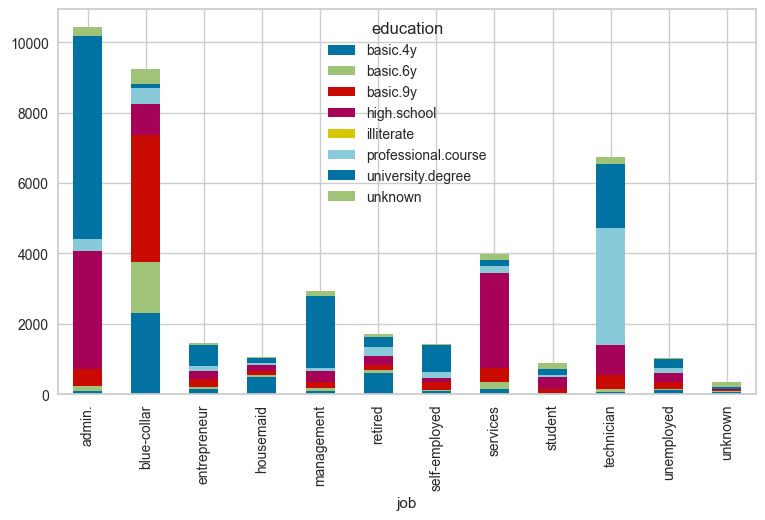

In [8]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(9,5),
                 stacked=True)

C1: Explore other categorical variables relationships</font>

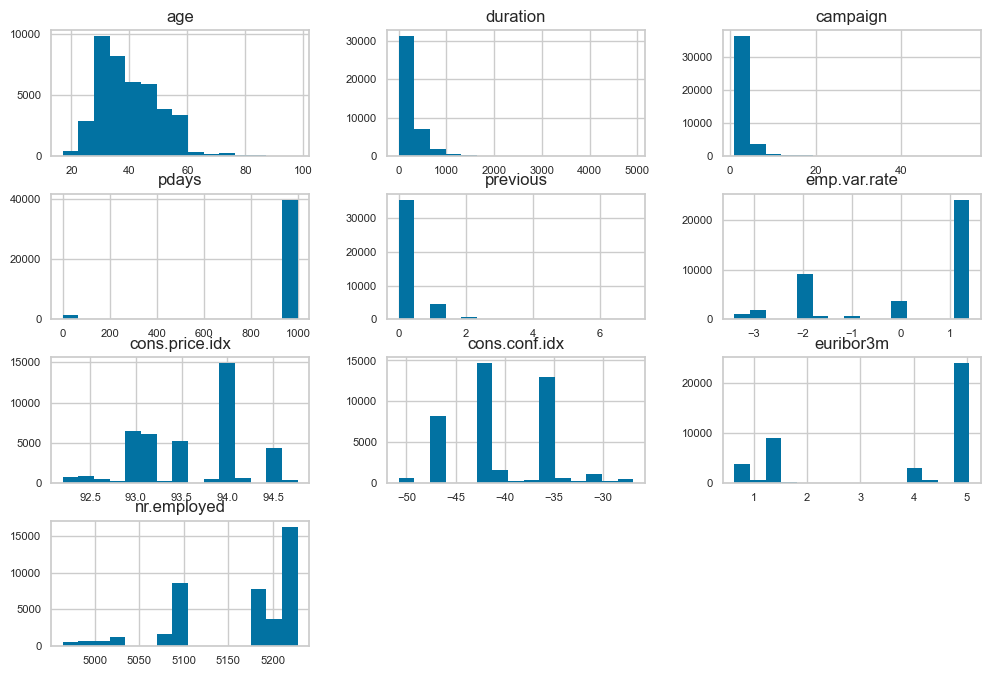

In [9]:
# Do histograms on all numeric variables
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=15, figsize=(12, 8), layout=(4, 3), xlabelsize=8, ylabelsize=8);

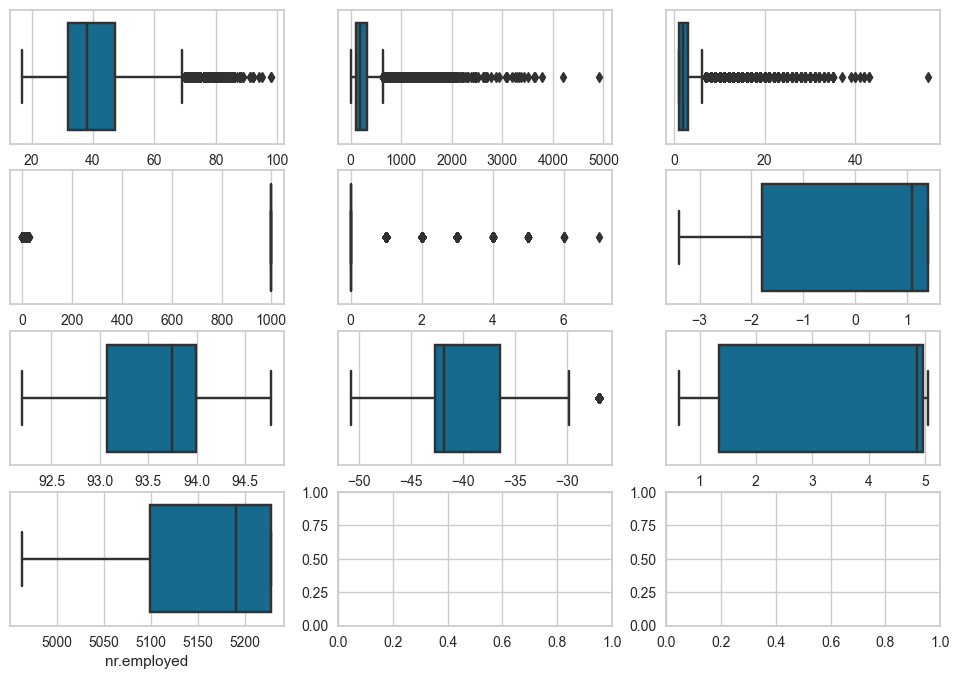

In [10]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(4, 3, figsize=(12, 8))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(x=ds[var], ax=subplot)
    

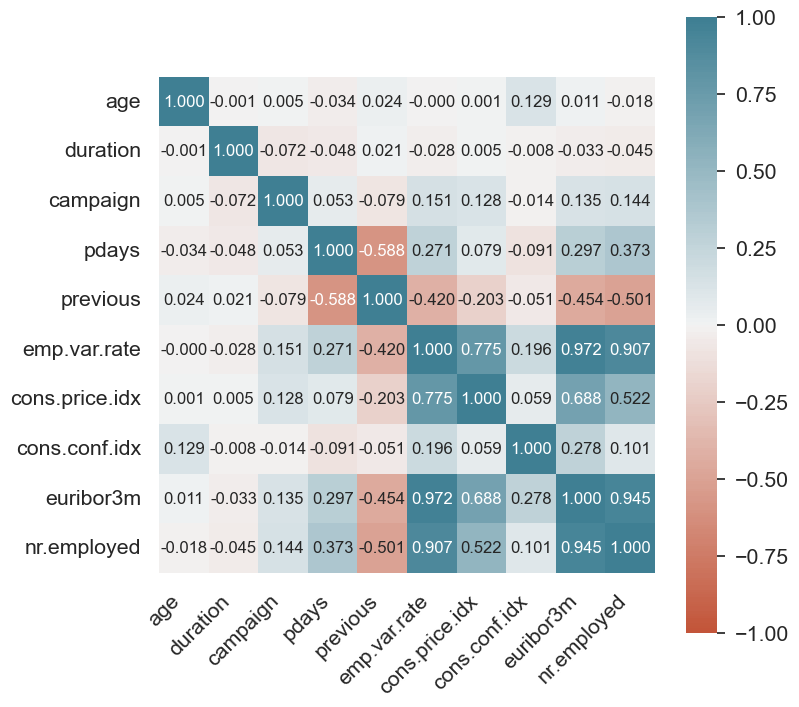

In [11]:
# Plot correlation heatmap of all numeric variables
corr = ds[numerical].corr()
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, annot_kws={"size": 12},
    fmt='.3f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

<AxesSubplot:xlabel='age', ylabel='Count'>

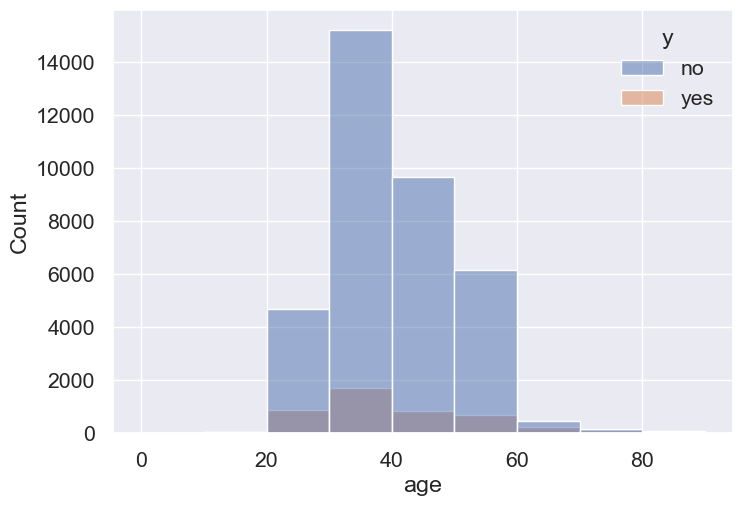

In [12]:
# Histogram age vs subscrition
bins = range(0, 100, 10)
sns.histplot(data=ds,x="age",hue="y",bins=bins)

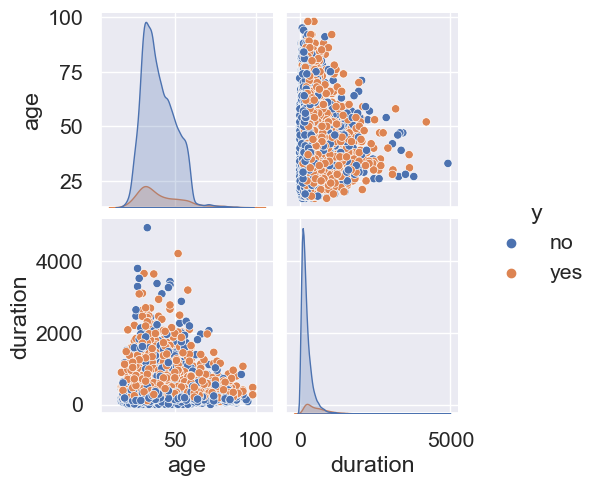

In [13]:
# Pairplot
sns.pairplot(data=ds, hue='y', vars= ['age', 'duration'])

### Data preparation

In [14]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [15]:
# Remove columns that should not be used as it may leak result
cols = ['contact', 'month', 'day_of_week', 'duration']
X.drop(columns=cols, inplace=True)

In [16]:
# Encode target to 0 (no) and 1 (yes)
X['y'] = X['y'].map({'yes': 1, 'no': 0})

In [17]:
# Encode categorical variables to dummy variables
cols = ['default', 'housing', 'loan', 'poutcome' ]
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [18]:
X.head()

,age,job,marital,education,default_no,default_unknown,default_yes,housing_no,housing_yes,housing_unknown,...,previous,poutcome_nonexistent,poutcome_failure,poutcome_success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,1,0,0,1,0,0,...,0,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,0,1,0,1,0,0,...,0,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,1,0,0,0,1,0,...,0,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,1,0,0,1,0,0,...,0,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,1,0,0,1,0,0,...,0,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0


In [19]:
# Encode multi-categorical variables to dummy variables (to avoid high cardinality and strange distributions)

# Function to return categories of columns based on threshold of distribution of the category
def one_hot(s, threshold,prefix):
    d = pd.get_dummies(s)
    f = pd.value_counts(s, sort=False, normalize=True) < threshold
    if f.sum() == 0:
        newSeries=d
    else:
        newSeries=d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('Other'))
    newSeries=newSeries.add_prefix(prefix)
    return newSeries

# One hot encoding of all categories above 15% - all others categories to "Other"
cols = ['job', 'marital', 'education']
for i in range(len(cols)):
    colToProcess = X[cols[i]].astype(str)
    procDF = one_hot(colToProcess, .15,cols[i]+'_')
    X.drop(columns=cols[i], inplace=True)
    X = pd.concat([X, procDF], axis=1)

### Modeling - SVM

In [20]:
# Create the Target
y = X['y']

In [21]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

In [22]:
# Remove the Target from the training
X_train = X_train.drop(['y'],axis=1)
X_test = X_test.drop(['y'],axis=1)

In [23]:
# Dataframe for scaling
tempDF = X.copy(deep=True)
tempDF.drop(columns='y', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Counter({0: 27411, 1: 3480})


<AxesSubplot:xlabel='y', ylabel='count'>

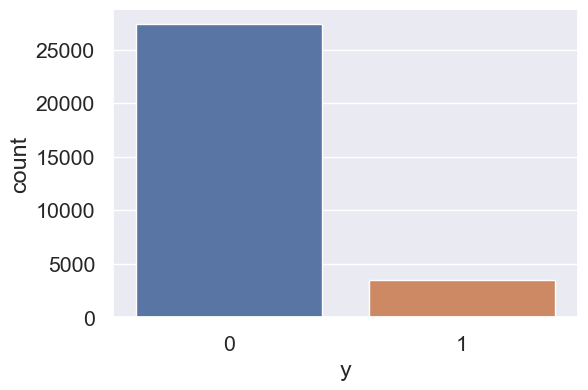

In [24]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train}), ax=ax)

Counter({1: 27411, 0: 27411})


<AxesSubplot:xlabel='y', ylabel='count'>

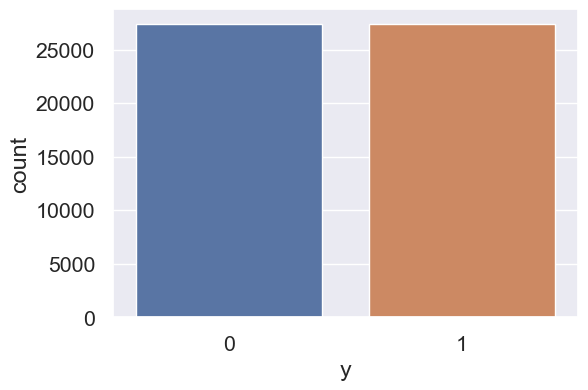

In [25]:
# Import package
from imblearn.over_sampling import SMOTE

# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train2}), ax=ax)

In [26]:
# Create object and train the model
classModel = svm.SVC(gamma='scale', random_state=123, probability=True)
classModel.fit(X_train_scaled2, y_train2)

SVC(probability=True, random_state=123)

### Evaluation - SVM

In [27]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train_scaled2) 
y_pred_test = classModel.predict(X_test_scaled) 

In [28]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest),
               metricsObj.f1_score(yTest, yPredTest),
               metricsObj.roc_auc_score(yTest, yPredTest)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [29]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

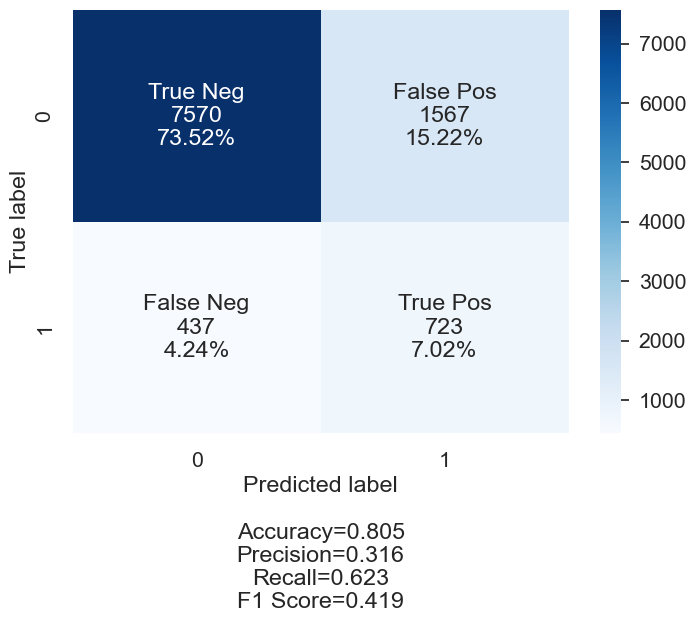

In [30]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [31]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.755226,0.805380
1,PRECISION,0.798388,0.315721
2,RECALL,0.682901,0.623276
3,F1 SCORE,0.736143,0.419130
4,AUC,0.755226,0.725888


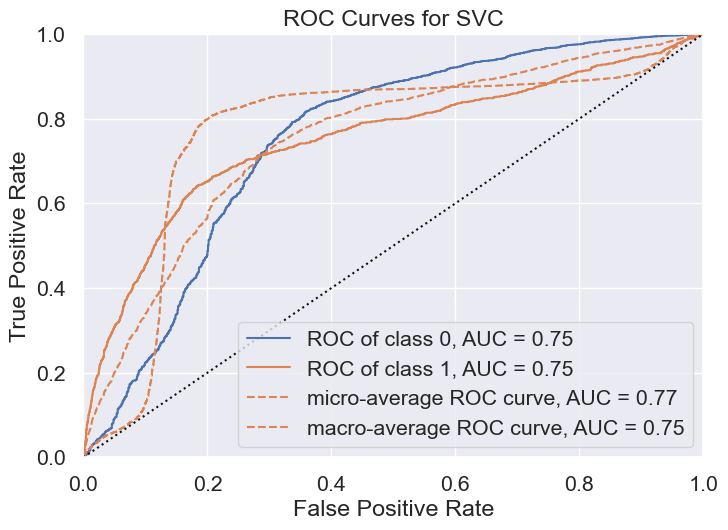

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [32]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train_scaled2, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

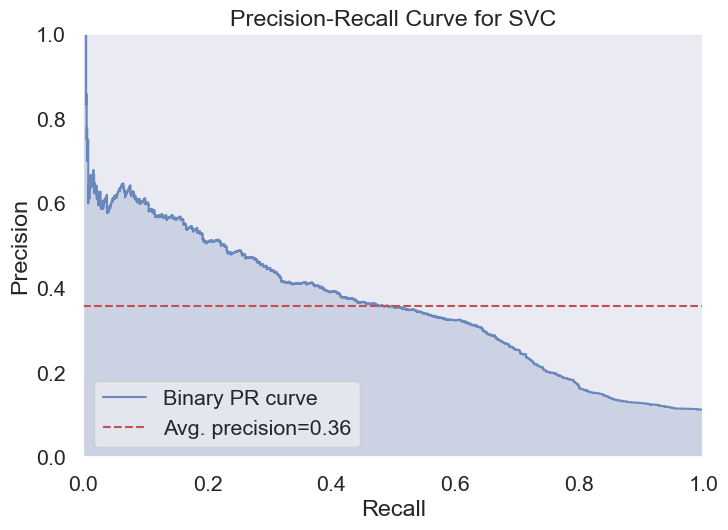

<AxesSubplot:title={'center':'Precision-Recall Curve for SVC'}, xlabel='Recall', ylabel='Precision'>

In [33]:
# Precison-Recall curve
visualizer = PrecisionRecallCurve(classModel, classes=['0','1'])
visualizer.fit(X_train_scaled2, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()